In [2]:
import skimage.data as skid
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

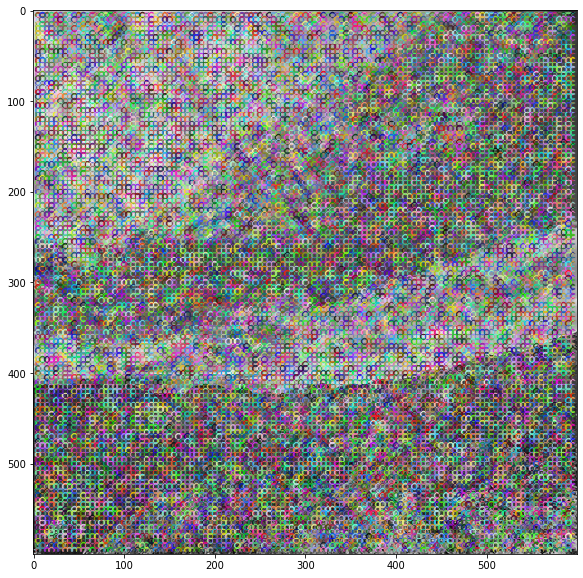

In [79]:
img = cv2.imread("test.jpg", 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

step_size = 5
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                                    for x in range(0, gray.shape[1], step_size)]
img = cv2.drawKeypoints(gray, kp, img)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [87]:
orb = cv2.ORB_create(edgeThreshold=0)
keypoints, features = orb.compute(gray, kp)

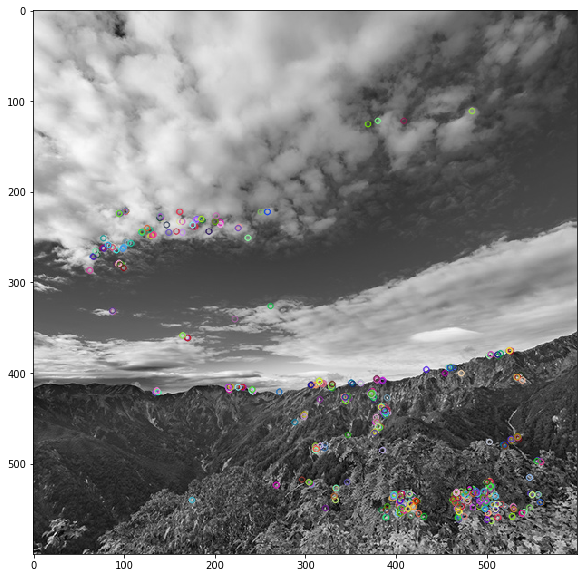

In [29]:
detected_kp = orb.detect(gray, None)
res = orb.compute(gray, detected_kp)
res[1].shape

img2 = cv2.drawKeypoints(gray, detected_kp, img)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [34]:
brisk = cv2.BRISK_create()
dense_brisk = brisk.compute(gray, kp)

# k-medoid

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelBinarizer
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from joblib import Parallel, delayed
import time

In [3]:
class KMedoids(object):
    def __init__(self, n_clusters, max_iter=300, tol=0, init="kmeans++", metric="euclidean", n_jobs=-1, init_search=5):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.loop_flag = True
        self.lb = LabelBinarizer()
        self.tol = tol
        self.num_loop = 0
        self.centroids = None
        self.last_centroids = set([0])
        self.init = init
        self.metric = metric
        # 初期値探索のみ並列して行う
        self.n_jobs = n_jobs
        # 初期値探索する回数
        self.init_search = init_search
        
    def fit(self, X):
        """
        データに対してクラスタリングを実施する
        X : 2D-np.array,  (n_samples, n_dim)
        """
        # 距離行列を指定したmetricで計算
        self.D = cdist(X, X, self.metric)
        self.n_samples, n_dim = X.shape
        
        # centroids初期値をinit_search回計算し、最もクラスタ内誤差が小さいcentroidsを初期値として使用する
        # init : list of tuple, [(score, centroids), ...]    length == self.init_search
        inits = Parallel(n_jobs=1)([delayed(self._init_centroids)() for i in range(self.init_search)])
        self.centroids = sorted(inits, key=lambda x:x[0])[0][1]
        
        # fit完了後に最新のラベルを参照できるようにするため、ループの最後にlabel更新を入れる
        # 一回目(初期値)のlabel更新はループ前で実施
        tmp_labels = self._make_labels(self.centroids)
        
        # 終了条件：centroidに変化なし  or  ループ回数がmax_iterに到達
        while (self.num_loop <= self.max_iter) and self.loop_flag:
            one_hot_labels = self._encode_labels_to_OneHot(tmp_labels)
            self._update_centroids(one_hot_labels)
            tmp_labels = self._make_labels(self.centroids)
            self.labels = tmp_labels
            self.num_loop += 1
            
    def get_BOWhistogram(self, X):
        if self.centroids is None:
            raise AttributeError("This object has not fitted yet, please do .fit() to training data")
        
        # train dataの距離行列を残しておくためにラッチ、あとから復元
        # (_make_labels()はself.Dを参照するため)
        fitted_data_D = self.D
        self.D = cdist(X, X, self.metric)
        
        # test dataがどのクラスタに属するかを計算
        labels = self._make_labels(self.centroids)
        # histogram計算、[0]:histogram(非正規化)　,   [1]:binの境界値を表すarray
        self.hist = np.histogram(labels, bins=self.n_clusters)[0]
        # histogram正規化(サンプル数で除算)
        self.hist = self.hist / X.shape[0]
        # train dataの距離行列を保持しておく
        self.D = fitted_data_D
        return self.hist
        
        
    def _init_centroids(self):
        """
        centroidの初期値を選択する
        self.init : "random"   ->  乱数で選択
                    "kmeans++" ->  初期centroidが近づきすぎないような確率分布に従って選択
        """
        if self.init == "kmeans++":
            centroids = []
            for n in range(self.n_clusters):
                if n == 0:
                    # 最初のセントロイドは乱数で決定する
                    centroid = np.random.choice(range(self.n_samples), 1, replace=False)
                    centroids.extend(centroid)
                else:
                    # 2つ目以降はkmeans++の方法で選択
                    
                    # centroidとして選ばれたサンプル以外から次のcentroidを選ぶ
                    remained_samples = set(range(self.n_samples)) - set(centroids)
                    remained_samples = list(remained_samples)
                    
                    # 各サンプルについて最近傍centroidとの距離を計算
                    distance = np.delete(self.D, centroids, axis=0)
                    distance = distance[:, centroids]
                    min_distance = distance.min(axis=1)
                    
                    # d(x_i)^2 / sum(d(x_i)^2) の確率分布に従い、次のcentroidを選ぶ
                    sqrd_min_distance = min_distance * min_distance
                    probs = sqrd_min_distance / sqrd_min_distance.sum()
                    centroid = np.random.choice(remained_samples, 1, p=probs)
                    centroids.extend(centroid)
            centroids = np.array(centroids)
        elif self.init == "random":
            centroids = np.random.choice(range(self.n_samples), self.n_clusters, replace=False)
        
        # 評価を計算
        score_of_init = self._eval_init(centroids)
        return (score_of_init, centroids)
            
    def _eval_init(self, centroids):
        """
        クラスタ内誤差の総和を計算する
        centroids初期値の評価に使用
        """
        labels = self._make_labels(centroids)
        one_hot_labels = self._encode_labels_to_OneHot(labels)
        D_in_clusters = (one_hot_labels[np.newaxis, :, :] * one_hot_labels[:, np.newaxis, :]).swapaxes(0, 2)
        D_in_clusters = D_in_clusters * self.D[np.newaxis, :, :]
        
        each_sample_D = np.sum(D_in_clusters).sum()
        return each_sample_D
                
    def _make_labels(self, centroids):
        """
        サンプルがどのクラスタに所属するかのラベルを計算する
        output: np.array,  self.labels  (shape=(n_samples,))
        """
        labels = np.argmin(self.D[:, centroids], axis=1)
        return labels
            
    def _encode_labels_to_OneHot(self, labels):
        if self.n_clusters == 2:
            result = np.hstack((labels.reshape(-1, 1), 1 - labels.reshape(-1, 1)))
        else:
            result = self.lb.fit_transform(labels)
        return result
    
    def _update_centroids(self, one_hot_labels):
        """
        1. それぞれのクラスタ内において、クラスタ内の他のすべての点との距離が最小になる点をcentroidとする
        2. centroidに変化がなければ終了する(self.loop_flag = False とする)
        """
        # 各クラスタ内の二点間の距離を計算する
        # D_in_clusters.shape == (n_clusters, n_samples, n_samples), 対象行列
        D_in_clusters = (one_hot_labels[np.newaxis, :, :] * one_hot_labels[:, np.newaxis, :]).swapaxes(0, 2)
        D_in_clusters = D_in_clusters * self.D[np.newaxis, :, :]
        
        # 各サンプルをcentroidとしたときの距離の総和が最小となる点を新たなcentroidとする
        each_sample_D = np.sum(D_in_clusters, axis=1)
        np.place(each_sample_D, each_sample_D == 0, float("inf"))
        self.centroids = np.argmin(each_sample_D, axis=1)
        
        # 終了条件判定
        self._judge_exit_condition()
        
    def _judge_exit_condition(self):
        unchanged_centroids = self.last_centroids.intersection(set(self.centroids))
        if len(unchanged_centroids) == self.n_clusters:
            self.loop_flag = False
        else:
            self.last_centroids = set(self.centroids)

In [72]:
x_data, labels = make_blobs(n_samples=300,
                                n_features=2,
                                centers=3,
                                cluster_std=3.0,
                                shuffle=True,
                                random_state=10)
km = KMedoids(n_clusters=3, n_jobs=2, init_search=1)
km.fit(x_data)
km.D.shape

(300, 300)

In [73]:
x_data, labels = make_blobs(n_samples=300,
                            n_features=2,
                            centers=10,
                            cluster_std=3.0,
                            shuffle=True,
                            random_state=16)
hist = km.get_BOWhistogram(x_data)

In [74]:
hist

array([0.37, 0.24, 0.39])

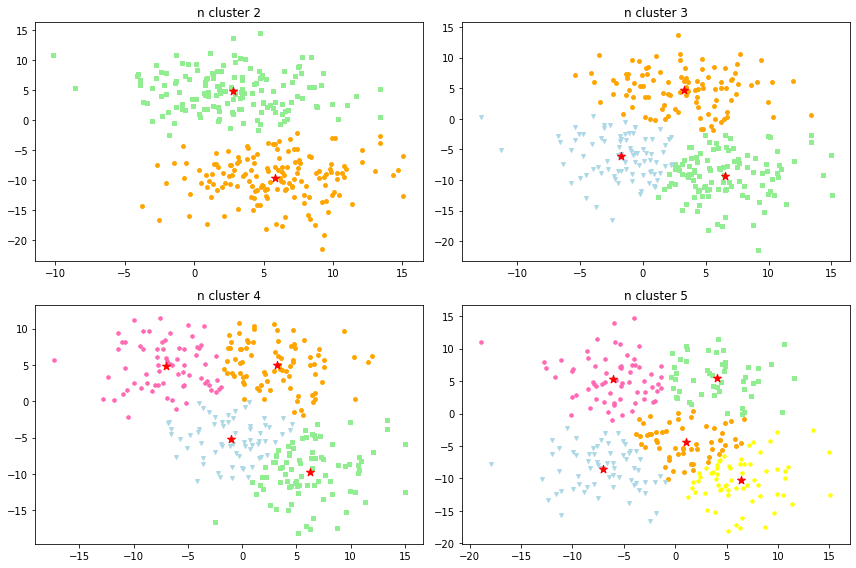

In [316]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

n_clusters = [2, 3, 4, 5]
colors = ['lightgreen', 'orange', 'lightblue', 'hotpink', 'yellow']
markers = ['s',              'o',         'v',       'h',      'p']

plt.figure(figsize=(12, 8))

for plot_num, n_cluster in enumerate(n_clusters):

    # 指定したクラスタ数のデータを作ってくれる
    # cluster_stdでデータの散らばり具合を調整できる
    x_data, labels = make_blobs(n_samples=300,
                                n_features=2,
                                centers=n_cluster,
                                cluster_std=3.0,
                                shuffle=True,
                                random_state=10)

    # k-meansは一行で行える
    # n_clustersでクラスタ数を指定し、initで初期化方法を指定している
    # initの初期化は「k-means++」であり、これは後ほど説明する
    km = KMeans(n_clusters=n_cluster, init="random")

    predicted_labels = km.fit_predict(x_data)
    centroids = km.cluster_centers_

    # クラスタリング結果の可視化
    plt.subplot(2, 2, plot_num+1)
    for i, label in enumerate(sorted(np.unique(predicted_labels))):
        # 分類した結果のクラスをプロット
        plt.scatter(x_data[predicted_labels==label, 0],
                    x_data[predicted_labels==label, 1],
                    c=colors[i],
                    marker=markers[i],
                    s=15)
    
    # 最終的なセントロイドをプロット
    plt.scatter(centroids[:, 0],
                centroids[:, 1],
                c='red',
                marker='*',
                s=70)

    plt.title('n cluster '+str(n_cluster))

plt.tight_layout()
# plt.savefig("kmeans.png")
plt.show()

In [11]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
from BOWtest import KMedoids
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np
import time

0.14872455596923828
0.19270658493041992
0.3284602165222168
0.4350275993347168


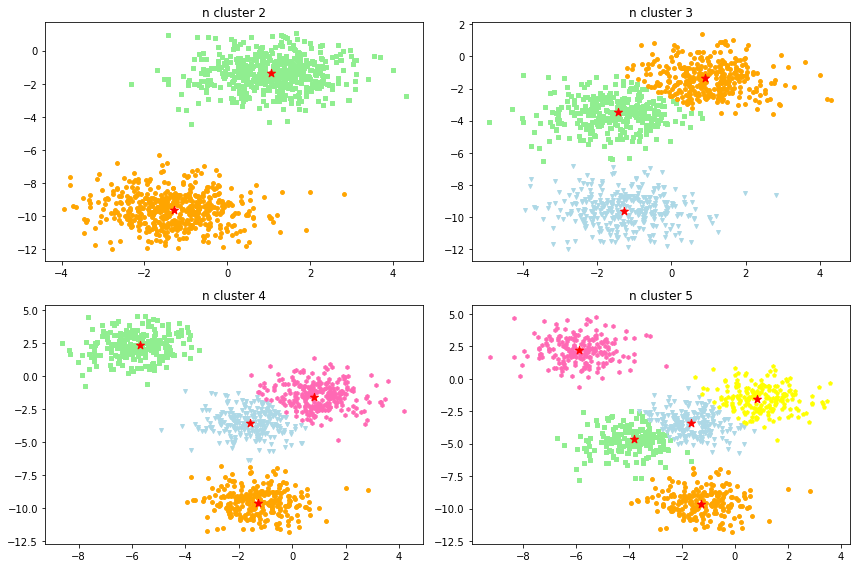

In [25]:
n_clusters = [2, 3, 4, 5]
colors = ['lightgreen', 'orange', 'lightblue', 'hotpink', 'yellow']
markers = ['s',              'o',         'v',       'h',      'p']

plt.figure(figsize=(12, 8))

for plot_num, n_cluster in enumerate(n_clusters):

    x_data, labels = make_blobs(n_samples=1000,
                                n_features=2,
                                centers=n_cluster,
                                cluster_std=1.0,
                                shuffle=True,
                                random_state=2)
#     ss = StandardScaler()
#     ms = MinMaxScaler()
#     x_data = ss.fit_transform(x_data)
#     x_data = ms.fit_transform(x_data)
    km = KMedoids(n_clusters=n_cluster, init_search=5, mem_save=True)
    
    start = time.time()
    km.fit(x_data)
    erapsed = time.time() - start
    print(erapsed)
    predicted_labels = km.labels
    medoids = km.medoids
    medoids = x_data[medoids, :]

    plt.subplot(2, 2, plot_num+1)
    for i, label in enumerate(sorted(np.unique(predicted_labels))):
        plt.scatter(x_data[predicted_labels==label, 0],
                    x_data[predicted_labels==label, 1],
                    c=colors[i],
                    marker=markers[i],
                    s=15)
    
    plt.scatter(medoids[:, 0],
                medoids[:, 1],
                c='red',
                marker='*',
                s=70)

    plt.title('n cluster '+str(n_cluster))

plt.tight_layout()
plt.show()

3

# ORBでKMedoids実施

In [13]:
img = cv2.imread("test.jpg", 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

step_size = 10
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                                    for x in range(0, gray.shape[1], step_size)]
img = cv2.drawKeypoints(gray, kp, img)

orb = cv2.ORB_create(edgeThreshold=0)
keypoints, features = orb.compute(gray, kp)

In [24]:
def convert_to_bin_feature(X):
    """
    uint8で表現された特徴をバイナリコードに変換する
    input: shape  = (n_samples, n_dim)
    output: shape = (n_samples, n_dim * 8)
    """
    # arrayの各要素を2進数表記(文字列)へ変換する
    b_format = np.frompyfunc(format, 2, 1)
    bin_str_X = b_format(X, "08b")

    # arrayの各要素をlistへ変換する(文字列表記の二進数をlistへ分割する)
    str2list_np = np.frompyfunc(list, 1, 1)
    # サンプルごとにlistを結合する
    # 次の処理でmap関数を使うため、list型に変換する
    # listを要素に持つnp.arrayに対してmapは使えないっぽい
    bin_list_X = str2list_np(bin_str_X).sum(axis=1).tolist()

    # 各要素が文字列となっているため、uint8へ変換
    char2int_np = np.frompyfunc(int, 1, 1)
    result = char2int_np(bin_list_X).astype(np.uint8)

    return result

In [91]:
km = KMedoids(n_clusters=100, metric="hamming")
km.fit(features)

KeyboardInterrupt: 